# Lensing Ray Tracing

This notebook demonstrates how to run a lensing lightcone in flowpm

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%pylab inline 
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
from itertools import cycle
import  DifferentiableHOS as DHOS

Populating the interactive namespace from numpy and matplotlib


In [85]:
# Below are a few parameters
n_lens = 22       # Number of lensplanes in the lightcone
box_size = 100.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 512  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel

In [23]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()

In [24]:
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])

# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)

In [25]:
# this should be the redshift of our last lens
1/a[-1] - 1

<tf.Tensor: shape=(), dtype=float32, numpy=0.9402157>

In [26]:
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [27]:
# Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [28]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 

In [ ]:
# Extract the lensplanes
lensplanes = []
matrix=flowpm.raytracing.generate_matrix()
for i,j in zip(range(len(a_center)),cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            matrix[j],
                                            flowpm.raytracing.shift(),
                                            width=nc,
                                            plane_resolution=256)

    plane = tf.expand_dims(plane, axis=-1)
    lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))
  

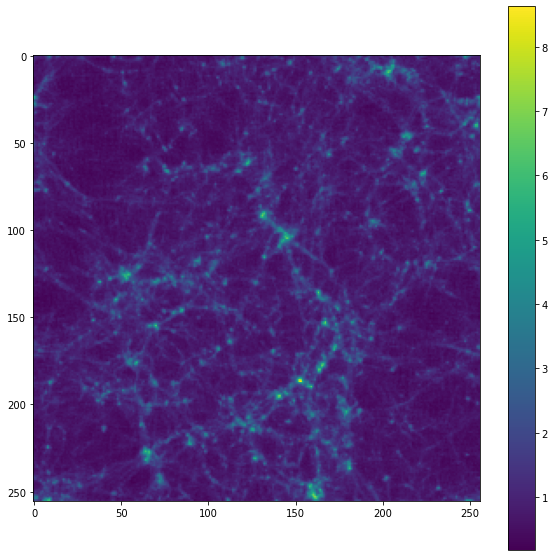

In [30]:
figure(figsize=[10,10])
imshow(plane[0])
colorbar()

In [ ]:
# Here are the lens planes exported during the simulation
figure(figsize=(50,5))
for i in range(20):
    subplot(1,20,i+1)
    imshow(lensplanes[i][-1][0],vmax=8)
    title('r=%f'%lensplanes[i][0])
    axis('off')

In [86]:
# Create a coordinate grid 
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [87]:
z_source = tf.linspace(0.5, 1, 4)

In [88]:
m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m = m.numpy().reshape([batch_size, field_npix, field_npix, -1])

In [89]:
z_source[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

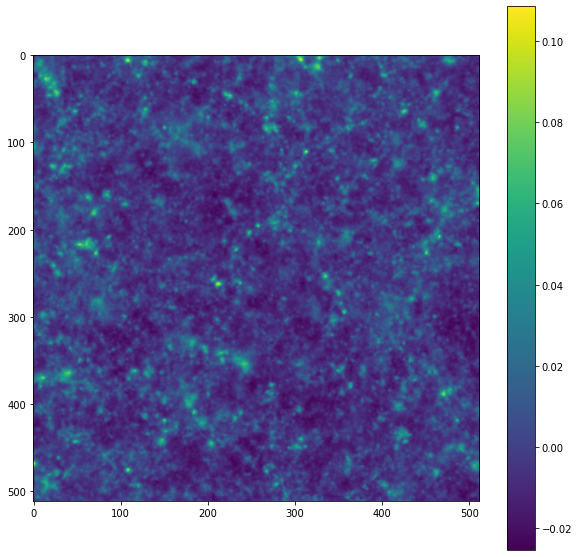

In [90]:
figure(figsize=[10,10])
imshow(m[0,:,:,-1]); colorbar();

## Bonus: comparing power spectrum to theory


In [1]:
import lenstools as lt
import astropy.units as u
import pyccl as ccl
import jax_cosmo as jc

ModuleNotFoundError: No module named 'pyccl'

In [92]:
cosmology.Omega_c.numpy()

0.2589

In [93]:
cosmology.Omega_b.numpy()

0.0486

In [94]:
cosmology.h.numpy()

0.6774

In [95]:
cosmology.sigma8.numpy()

0.8159

In [96]:
cosmology.n_s.numpy()

0.9667

In [97]:
# We first define equivalent CCL and jax_cosmo cosmologies
cosmo_ccl = ccl.Cosmology(
    Omega_c=0.2589, Omega_b=0.0486, 
    h=0.6774, sigma8 = 0.8159, n_s=0.9667, Neff=0,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')

In [119]:
tracers = []
for i in range(len(z_source)):
    z = linspace(0,2,2048)
    pz = zeros_like(z)
    pz[argmin(abs(z_source[i] - z))] = 1. 
    nzs_s=jc.redshift.kde_nz(z, pz, bw=0.01)
    tracers.append(ccl.WeakLensingTracer(cosmo_ccl, (z, nzs_s(z)), use_A_ia=False))

In [120]:
l_edges = np.logspace(2.2,4, 16) 

In [121]:
ps = np.stack([lt.ConvergenceMap(m[0,:,:,i], field_size*u.deg).powerSpectrum(l_edges)[1] for i in range(len(z_source))], axis=0)
l, _ = lt.ConvergenceMap(m[0,:,:,-1], field_size*u.deg).powerSpectrum(l_edges)

In [122]:
cl_ccl = np.stack([
    ccl.angular_cl(cosmo_ccl, t, t, l) for t in tracers    
])

Text(0.5, 1.0, 'Comparison to CCL halofit (dashed)')

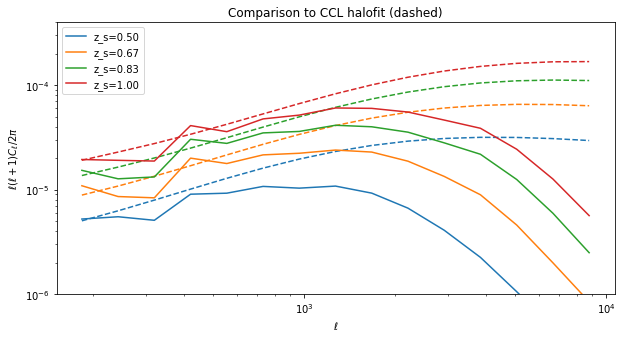

In [124]:
figure(figsize=[10,5])
for i in range(len(z_source)):
    loglog(l, l*(l+1)*ps[i]/(2*pi), color="C%d"%i, label="z_s=%0.2f"%z_source[i])
    loglog(l, l*(l+1)*cl_ccl[i]/(2*pi), '--', color="C%d"%i)
    

legend()
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
ylim(1e-6,4e-4)
xlabel('$\ell$')
title('Comparison to CCL halofit (dashed)')